## Libraries and Data

In [1]:
# Import needed libraries
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.spatial import distance_matrix

from ortools.graph import pywrapgraph
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

from glob import glob

In [2]:
# Import data and convert to integers
with open('busy_day.in') as f:
    read_data = f.read().splitlines()
data = [[int(num) for num in line.split()] for line in read_data]

## Exploratory Data Analysis

### Parameters of the Simulation

In [3]:
# Rows
total_rows = data[0][0]
# Columns
total_cols = data[0][1]
# Number of drones
drones_total = data[0][2]
# Maximum number of turns
max_turns = data[0][3]
# Maximum payload weight
max_payload = data[0][4]

print(f'Simulation Space Dimensions: {total_rows}x{total_cols} \nTotal Number of Drones: {drones_total}\
      \nMaxium Payload(weight): {max_payload} \nMaxium Number of Turns: {max_turns}')

Simulation Space Dimensions: 400x600 
Total Number of Drones: 30      
Maxium Payload(weight): 200 
Maxium Number of Turns: 112993


### Product Data

In [4]:
# Number of products
total_products = data[1][0]

print(f'Total Number of Products: {total_products}')

Total Number of Products: 400


In [5]:
# List of each product's weight
product_weight_list = data[2]

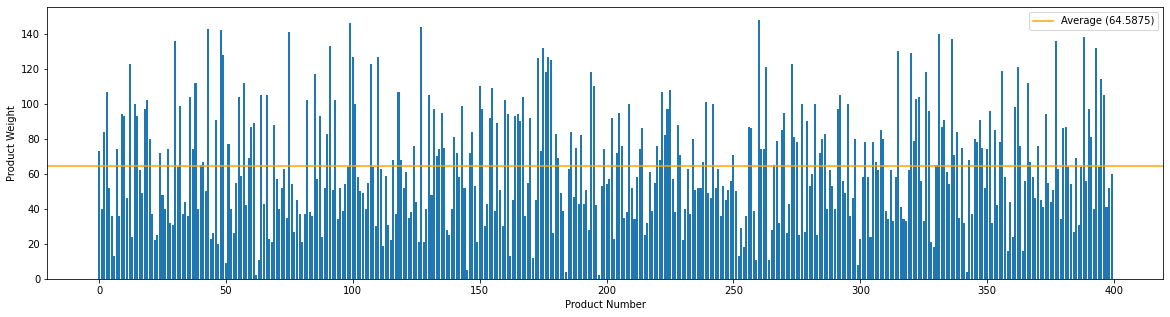

In [6]:
# Visualize each product's weight and the average weight
x = np.arange(total_products)
y = np.array(product_weight_list)

fig, ax = plt.subplots(figsize=(20, 5))

ax.bar(x,y)
mean_label = 'Average (' + str(y.mean()) + ')'
ax.axhline(y.mean(), color='orange', linewidth=1.5, label=mean_label)
ax.set_xlabel('Product Number')
ax.set_ylabel('Product Weight')
ax.legend()

plt.show()

In [7]:
# Create dataframe for product data
product_df = pd.DataFrame({'product_id': x, 'product_weight': y})
product_df.describe()

,product_id,product_weight
count,400.000000,400.000000
mean,199.500000,64.587500
std,115.614301,32.347151
min,0.000000,2.000000
25%,99.750000,39.000000
50%,199.500000,59.500000
75%,299.250000,87.000000
max,399.000000,148.000000


### Warehouse Data

In [8]:
# Number of Warehouses
total_warehouses = data[3][0]

In [9]:
# Seperate the warehouse data
warehouse_last_line = (total_warehouses*2)+3
warehouse_data = data[4:warehouse_last_line+1]

In [10]:
# Create list of warehouse locations and inventories
warehouse_location_list = warehouse_data[0::2]
warehouse_inventory_list = warehouse_data[1::2]

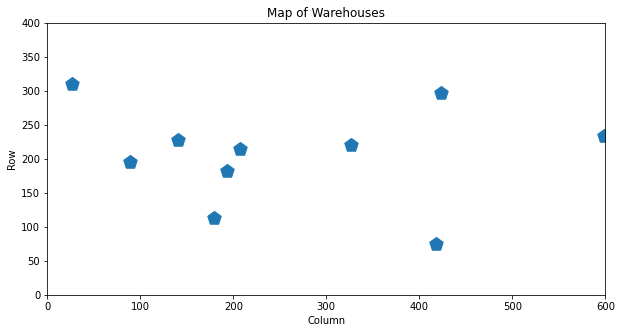

In [11]:
# Plot warehouse locations
x = [location[1] for location in warehouse_location_list]
y = [location[0] for location in warehouse_location_list]

fig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(x,y, marker='p', s=200)
ax.set_title('Map of Warehouses')
ax.set_xlabel('Column')
ax.set_ylabel('Row')
ax.set(xlim=(0, total_cols), ylim=(0, total_rows))

plt.show()

In [12]:
# Create dataframe for warehouse data
warehouse_id = range(total_warehouses)
warehouse_df = pd.DataFrame({'warehouse_id':warehouse_id, 'warehouse_row': y, 'warehouse_column': x})

In [13]:
# Add product inventory for each product
for product_id in range(total_products):
    column_name = 'inventory_product_' + str(product_id)
    product_inventory = [inventory[product_id] for inventory in warehouse_inventory_list]
    warehouse_df[column_name] = product_inventory

In [14]:
warehouse_df

,warehouse_id,warehouse_row,warehouse_column,inventory_product_0,inventory_product_1,inventory_product_2,inventory_product_3,inventory_product_4,inventory_product_5,inventory_product_6,...,inventory_product_390,inventory_product_391,inventory_product_392,inventory_product_393,inventory_product_394,inventory_product_395,inventory_product_396,inventory_product_397,inventory_product_398,inventory_product_399
0,0,113,179,0,0,5,1,0,0,0,...,3,2,0,2,0,0,11,6,7,0
1,1,234,599,0,0,3,1,1,0,0,...,7,9,0,1,0,0,5,7,11,0
2,2,195,89,0,0,1,3,0,0,0,...,3,0,0,1,0,0,5,5,5,0
3,3,215,207,1,0,4,0,1,0,15,...,3,4,0,3,0,0,6,5,8,0
4,4,220,326,1,0,6,1,2,0,0,...,3,0,0,3,25,0,2,2,6,0
5,5,182,193,0,16,3,0,1,0,0,...,2,2,0,1,0,33,5,9,5,0
6,6,75,418,1,0,6,0,1,0,0,...,3,6,0,2,0,0,5,5,5,60
7,7,228,140,0,0,6,0,0,0,0,...,2,1,61,1,0,0,8,6,9,0
8,8,310,26,1,0,8,1,0,33,0,...,4,3,0,1,0,0,11,6,13,0
9,9,297,423,1,0,4,2,0,0,0,...,3,6,0,2,0,0,7,5,6,0


In [15]:
# Add inventory data to the product dataframe
for warehouse_id in range(total_warehouses):
    column_name = 'inventory_warehouse_' + str(warehouse_id)
    product_df[column_name] =  warehouse_inventory_list[warehouse_id]

In [16]:
product_df

,product_id,product_weight,inventory_warehouse_0,inventory_warehouse_1,inventory_warehouse_2,inventory_warehouse_3,inventory_warehouse_4,inventory_warehouse_5,inventory_warehouse_6,inventory_warehouse_7,inventory_warehouse_8,inventory_warehouse_9
0,0,73,0,0,0,1,1,0,1,0,1,1
1,1,40,0,0,0,0,0,16,0,0,0,0
2,2,84,5,3,1,4,6,3,6,6,8,4
3,3,107,1,1,3,0,1,0,0,0,1,2
4,4,52,0,1,0,1,2,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
395,395,114,0,0,0,0,0,33,0,0,0,0
396,396,105,11,5,5,6,2,5,5,8,11,7
397,397,41,6,7,5,5,2,9,5,6,6,5
398,398,52,7,11,5,8,6,5,5,9,13,6


### Order and Customer Data

In [34]:
# Number of orders
total_orders = data[warehouse_last_line+1][0]

print(f'Total Number of Orders: {total_orders}')

Total Number of Orders: 1250


In [18]:
# Find order data
orders_last_line = len(data)
order_data = data[warehouse_last_line+2:orders_last_line+1]

In [19]:
# Create list of order locations, number of products, and product id's
order_location_list = order_data[0::3]
order_num_product_list = order_data[1::3]
order_product_id_list = order_data[2::3]
order_product_id_list = [sorted(product_id_list) for product_id_list in order_product_id_list]

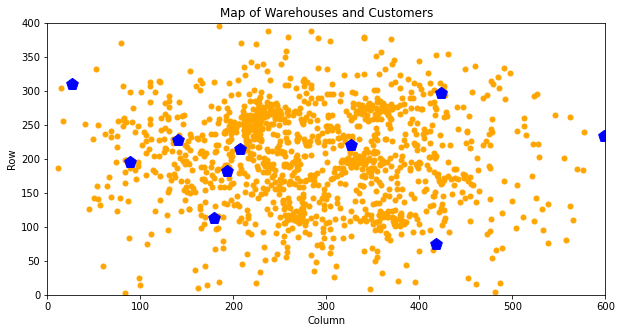

In [20]:
# Plot warehouse and customer locations
warehouse_x = [location[1] for location in warehouse_location_list]
warehouse_y = [location[0] for location in warehouse_location_list]
customer_x = [location[1] for location in order_location_list]
customer_y = [location[0] for location in order_location_list]

fig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(customer_x,customer_y, marker='o', s=25, color='orange')
ax.scatter(warehouse_x,warehouse_y, marker='p', s=150, color='blue')

ax.set_title('Map of Warehouses and Customers')
ax.set_xlabel('Column')
ax.set_ylabel('Row')
ax.set(xlim=(0, total_cols), ylim=(0, total_rows))

plt.show()

In [21]:
# Create a dataframe for orders
order_id = range(total_orders)
number_of_products = [products[0] for products in order_num_product_list]
orders_df = pd.DataFrame({'order_id':order_id, 'customer_row': customer_y, 'customer_column': customer_x, 'total_products': number_of_products})

In [22]:
orders_df

,order_id,customer_row,customer_column,total_products
0,0,340,371,8
1,1,163,320,1
2,2,201,331,2
3,3,257,290,10
4,4,115,512,8
...,...,...,...,...
1245,1245,138,331,8
1246,1246,109,273,8
1247,1247,161,291,14
1248,1248,127,152,5


In [23]:
# Check if there are multiple orders per customer (area for optimization)
group_row_col_df = orders_df.groupby(['customer_column', 'customer_row']).order_id.agg(['count'])
group_row_col_df.describe()

,count
count,1243.000000
mean,1.005632
std,0.074862
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,2.000000


In [24]:
# Add products to order dataframe (later)

### Drone Data

In [25]:
# Create a dataframe for drones
drone_id = range(drones_total)
drones_df = pd.DataFrame({'drone_id':drone_id, 'drone_row': warehouse_y[0], 'drone_column': warehouse_x[0], 'max_payload': max_payload,\
                          'current_payload': 0})

In [26]:
# Show basic statistics for drones_df
drones_df.describe()

,drone_id,drone_row,drone_column,max_payload,current_payload
count,30.000000,30.0,30.0,30.0,30.0
mean,14.500000,113.0,179.0,200.0,0.0
std,8.803408,0.0,0.0,0.0,0.0
min,0.000000,113.0,179.0,200.0,0.0
25%,7.250000,113.0,179.0,200.0,0.0
50%,14.500000,113.0,179.0,200.0,0.0
75%,21.750000,113.0,179.0,200.0,0.0
max,29.000000,113.0,179.0,200.0,0.0


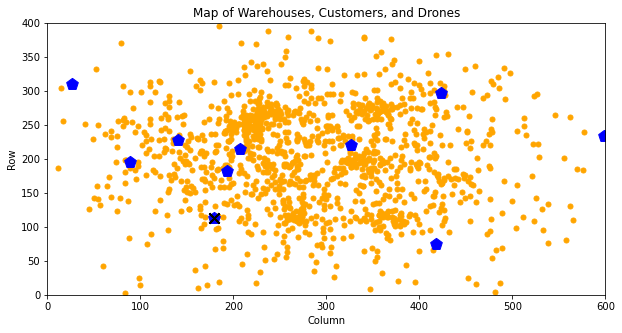

In [27]:
# Plot warehouse, customer locations and drones
warehouse_x = [location[1] for location in warehouse_location_list]
warehouse_y = [location[0] for location in warehouse_location_list]
customer_x = [location[1] for location in order_location_list]
customer_y = [location[0] for location in order_location_list]
drone_x = [179 for drone in range(drones_total)]
drone_y = [113 for drone in range(drones_total)]

fig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(customer_x,customer_y, marker='o', s=25, color='orange')
ax.scatter(warehouse_x,warehouse_y, marker='p', s=150, color='blue')
ax.scatter(drone_x,drone_y, marker='x', s=100, color='black')

ax.set_title('Map of Warehouses, Customers, and Drones')
ax.set_xlabel('Column')
ax.set_ylabel('Row')
ax.set(xlim=(0, total_cols), ylim=(0, total_rows))

plt.show()

## Optimization

### Warehouse Assignment (Minimum Cost Flow)

In [28]:
# Find the distance between all warehouses and customers
warehouse_locations = np.array(warehouse_location_list).astype(np.int16)
customer_locations = np.array(order_location_list).astype(np.int16)

w_c_distances = distance_matrix(warehouse_locations, customer_locations)

In [29]:
# Find the supply from warehouses
warehouse_supply = np.array(warehouse_inventory_list).transpose().astype(np.int16)

In [30]:
# Find the demand from orders
order_demand = np.zeros((data[1][0], data[warehouse_last_line+1][0]), dtype=np.int16)
for i,order in enumerate(order_product_id_list):
    for product in order:
        order_demand[product, i] += 1
order_demand.astype(np.int16)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

#### Google OR Tools (Minimum Cost Flow Solver)

In [31]:
# Solve for each product
assignments = []
count = 0

for i in range(total_products):
    item_count = 0
    
    # Set up network for Google OR Tools (Minimum Cost Flow Solver)
    start_nodes = np.repeat(np.arange(1250,1260), 1250).tolist()
    end_nodes = np.tile(np.arange(0,1250), 10).tolist()        
    capacities = np.tile(order_demand[i], 10).tolist()
    costs = w_c_distances.ravel().astype(int).tolist()
    supply = np.negative(order_demand[i]).tolist() + warehouse_supply[i].tolist()
    
    # Instantiate a SimpleMinCostFlow solver
    min_cost_flow = pywrapgraph.SimpleMinCostFlow()
    
    # Add each arc
    for j in range(0, len(start_nodes)):
        min_cost_flow.AddArcWithCapacityAndUnitCost(start_nodes[j], end_nodes[j], capacities[j], costs[j])
        
    # Add node supplies
    for k in range(0, len(supply)):
        min_cost_flow.SetNodeSupply(k, supply[k])
        
    # Solve
    if min_cost_flow.SolveMaxFlowWithMinCost() == min_cost_flow.OPTIMAL:
        for arc in range(min_cost_flow.NumArcs()):
            if min_cost_flow.Flow(arc) > 0:
                warehouse = min_cost_flow.Tail(arc) - 1250
                customer = min_cost_flow.Head(arc)
                product = i
                quant = min_cost_flow.Flow(arc)
                cost = min_cost_flow.UnitCost(arc)
                assign = [warehouse, customer, product, quant, cost]
                assignments.append(assign)
                item_count += quant
    count += item_count
    
print(warehouse_supply.sum(), order_demand.sum(), count) 

# Format final assignments
assignments_array = np.array(assignments)

14576 9368 9368


In [59]:
assign_df = pd.DataFrame(assignments_array, columns=['warehouse_id', 'order_id', 'product_number', 'quantity', 'distance'])
assign_df

,warehouse_id,order_id,product_number,quantity,distance
0,3,187,0,1,36
1,4,777,0,1,176
2,5,99,1,1,159
3,5,148,1,1,88
4,5,295,1,1,89
...,...,...,...,...,...
9231,6,1169,399,1,175
9232,6,1180,399,1,211
9233,6,1181,399,1,269
9234,6,1207,399,1,85


In [61]:
assign_df.describe()

,warehouse_id,order_id,product_number,quantity,distance
count,9236.000000,9236.000000,9236.000000,9236.000000,9236.000000
mean,4.573408,616.945106,201.563123,1.014292,131.242096
std,2.785243,357.747864,114.835673,0.120509,102.106678
min,0.000000,0.000000,0.000000,1.000000,2.000000
25%,3.000000,307.000000,105.000000,1.000000,56.000000
50%,5.000000,611.000000,198.000000,1.000000,97.000000
75%,7.000000,933.000000,298.250000,1.000000,186.000000
max,9.000000,1249.000000,399.000000,3.000000,588.000000


### Order Sequence (Capacited Vehicles Routing Problem) (Re-Working)

In [95]:
# From https://www.kaggle.com/jpmiller/application-of-google-or-tools

assign_df = pd.DataFrame(assignments_array, columns=['wh', 'cust', 'prod_', 'quant', 'dist'])
weights = np.array(product_weight_list).astype(np.int16)
top_line = data[0]
params = {'DRONE_COUNT': top_line[2],'WT_CAP': top_line[4],'END_TIME': top_line[3],}
wh_locs = warehouse_locations
cust_locs = customer_locations

In [96]:

def order_orders(df):
    
    customers = assign_df.cust.unique()
    demand = assign_df.groupby('cust')['quant'].sum()
    locs = np.vstack((customer_locations[customers], warehouse_locations[0]))
    distances = np.ceil(distance_matrix(locs, locs)).astype(int)
    customer_map = dict(zip(customers, range(len(customers))))
    
    data = {}
    data['dists'] = distances.tolist()
    data['drone_count'] = 1
    data['warehouse'] = len(locs) - 1

    # Create the routing index manager
    manager = pywrapcp.RoutingIndexManager(len(data['dists']),
                                           data['drone_count'], data['warehouse'])

    routing = pywrapcp.RoutingModel(manager)

    # Create and register a transit callback
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['dists'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    
    # Setting first solution heuristic
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
            routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Solve the problem
    solution = routing.SolveWithParameters(search_parameters)

    # Get vehicle routes
    routes = []
    for route_nbr in range(routing.vehicles()):
        index = routing.Start(route_nbr)
        route = [manager.IndexToNode(index)]
    while not routing.IsEnd(index):
      index = solution.Value(routing.NextVar(index))
      route.append(manager.IndexToNode(index))
    routes.append(route[1:-1])

    # Single vehicle approximation
    route = routes[0]
    
    reverse_dict = {v: k for k,v in customer_map.items()}
    cust_ids = [reverse_dict[r] for r in route]

    df['cust_sort'] = pd.Categorical(df.cust, cust_ids)
    df = df.sort_values('cust_sort')
    return df


In [97]:
def load_drones(df):
    test_wt = 0
    load_wts = []
    df = df.sort_values('cust')
    for i,tup in enumerate(df.itertuples()):
        test_wt += tup.weight
        if test_wt <= params['WT_CAP']:
            load_wt = test_wt
        else:
            load_wt = tup.weight
            test_wt = tup.weight
        load_wts.append(load_wt)

    df['load_weight'] = load_wts
    df['load_tag'] = df.load_weight.eq(df.weight).cumsum()-1
    return df


In [98]:
def set_loads(assignments):
    assign_df = pd.DataFrame(assignments, columns=['wh', 'cust', 'prod_',
                                                   'quant', 'dist'])
    # Monster method chain to deal with quantities > 1 and define loads
    assign_df = assign_df.reindex(assign_df.index.repeat(assign_df.quant)) \
                         .reset_index(drop=True) \
                         .assign(quant=1,
                                 weight = lambda x: weights[x.prod_.to_numpy()],
                                 work = lambda x: x.dist * x.weight) \
                         .groupby('wh', as_index=False).apply(load_drones) \
                         .sort_values(['wh', 'cust', 'load_tag']) \
                         .reset_index(drop=True)
    return assign_df

In [99]:
def assign_drones(assign_df):
    wh_work = assign_df.groupby('wh')['work'].sum()
    drones_per_wh = (wh_work/ wh_work.sum()
                         * params['DRONE_COUNT'])
    drone_counts = drones_per_wh.round(0).astype(int)

    if drone_counts.sum() != params['DRONE_COUNT']:
        drone_counts = np.ediff1d(drones_per_wh.cumsum().round(0).astype(int),
                                        to_begin=drone_counts[0])

    drone_whs = np.repeat(np.arange(len(wh_locs)), drone_counts)
    drone_dict = dict(zip(range(params['DRONE_COUNT']), drone_whs))

    drone_assigns = {}
    for k, v in drone_dict.items():
        drone_assigns[v] = drone_assigns.get(v, []) + [k]

    df_list = []
    for grp, df in assign_df.groupby('wh'):
        drone_ids = drone_assigns[df.wh.iloc[0]]
        df['drone_id'] = df.load_tag % len(drone_ids) + min(drone_ids)
        df_list.append(df)

    df_end = pd.concat(df_list)
    return df_end


In [100]:
# main 
assign_df = set_loads(assignments)
df_end = assign_drones(assign_df)
df_end = df_end.groupby(['wh', 'cust', 'load_tag', 'drone_id', 'prod_'],
                            as_index=False)['quant'].sum()
df_end

,wh,cust,load_tag,drone_id,prod_,quant
0,0,5,0,0,43,1
1,0,6,0,0,179,1
2,0,8,1,1,16,1
3,0,8,1,1,26,1
4,0,9,1,1,243,1
...,...,...,...,...,...,...
9303,9,1244,433,28,52,1
9304,9,1244,433,28,58,1
9305,9,1245,433,28,69,1
9306,9,1246,434,29,58,1


In [101]:
def load_drones_improved(df):
    test_wt = 0
    load_wts = []
    for i,tup in enumerate(df.itertuples()):
        test_wt += tup.weight
        if test_wt <= params['WT_CAP']:
            load_wt = test_wt
        else:
            load_wt = tup.weight
            test_wt = tup.weight
        load_wts.append(load_wt)

    df['load_weight'] = load_wts
    df['load_tag'] = df.load_weight.eq(df.weight).cumsum()-1
    return df


def reset_loads(df_end_reordered):
    df_end_reordered = df_end_reordered.reset_index(drop=True) \
                                 .assign(weight = lambda x: weights[x.prod_.to_numpy()] * x.quant) \
                                 .groupby('wh', as_index=False).apply(load_drones_improved)
    return df_end_reordered


def assign_drones(df_end_reordered):
    df_list = []
    for grp, df in df_end_reordered.groupby('wh'):
        drone_ids = df.wh.iloc[0]
        df['drone_id'] = df.load_tag % df.drone_id.nunique() + min(df.drone_id)
        df_list.append(df)

    df_end = pd.concat(df_list)
    return df_end


In [102]:
df_end_reordered = df_end.groupby('wh').apply(order_orders) \
                         .pipe(reset_loads) \
                         .pipe(assign_drones)

df_end_reordered

,wh,cust,load_tag,drone_id,prod_,quant,cust_sort,weight,load_weight
0,0,777,0,0,150,1,777,110,110
1,0,777,1,1,225,1,777,108,108
2,0,777,2,2,277,1,777,100,100
3,0,777,2,2,62,1,777,2,102
4,0,193,2,2,15,1,193,93,195
...,...,...,...,...,...,...,...,...,...
9303,9,176,433,28,235,1,176,51,51
9304,9,1001,433,28,25,1,1001,48,99
9305,9,1001,433,28,386,1,1001,31,130
9306,9,922,433,28,116,1,922,68,198


## Create Output File (Re-Writing)

In [ ]:
df_end_loading = df_end_reordered.groupby(['wh', 'load_tag', 'prod_'], as_index=False).agg(
                                    drone_id = ('drone_id', 'first'),
                                    quant = ('quant', 'sum'),
                                     weight_sum = ('weight', 'sum')
                                    )
df_end_loading

,wh,load_tag,prod_,drone_id,quant,weight_sum
0,0,0,150,0,1,110
1,0,1,225,1,1,108
2,0,2,15,2,1,93
3,0,2,62,2,1,2
4,0,2,277,2,1,100
...,...,...,...,...,...,...
9088,9,433,25,28,1,48
9089,9,433,116,28,1,68
9090,9,433,235,28,1,51
9091,9,433,386,28,1,31


In [ ]:
def write_instrux(df_load, df_deliver, sub):
    line_count_load = 0
    for tup in df_load.itertuples():
        sub.write(f"{tup.drone_id} L {tup.wh} {tup.prod_} {tup.quant}\n")
        line_count_load +=1
    for tup in df_deliver.itertuples():
        sub.write(f"{tup.drone_id} D {tup.cust} {tup.prod_} {tup.quant}\n")
        line_count_load +=1
    return line_count_load


with open('submission.csv', 'w') as sub:
    sub.write(f"{len(df_end_loading) + len(df_end_reordered)}\n")
    line_count = 0    
    
    drone_tag = df_end_loading.drop_duplicates(['drone_id', 'load_tag'])

    for dt in drone_tag.itertuples():
        df_load_tag = df_end_loading[(df_end_loading.load_tag == dt.load_tag) & \
                                          (df_end_loading.drone_id == dt.drone_id)]
        df_deliver_tag = df_end_reordered[(df_end_reordered.load_tag == dt.load_tag) & \
                                          (df_end_reordered.drone_id == dt.drone_id)]
    
        line_count_load = write_instrux(df_load_tag, df_deliver_tag, sub)
        line_count += line_count_load

print(len(df_end_loading) + len(df_end_reordered), line_count)

18401 18401
